In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source("tests.R")
source('cleanup.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
nba<-read_csv("nba_2022-23.csv") #reading the dataset
nba

New names:
• `` -> `...1`
Rows: 467 Columns: 52
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Player Name, Position, Team
dbl (49): ...1, Salary, Age, GP, GS, MP, FG, FGA, FG%, 3P, 3PA, 3P%, 2P, 2PA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,⋯,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,⋯,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,⋯,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,⋯,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
464,Gabe York,32171,SG,29,IND,3,0,18.7,2.7,⋯,0.0,16.4,0.1,0.0,0.1,0.091,-1.7,-1.8,-3.5,0
465,RaiQuan Gray,5849,PF,23,BRK,1,0,35.0,6.0,⋯,23.7,21.4,0.0,0.0,0.1,0.106,-0.6,-1.4,-2.0,0
466,Jacob Gilyard,5849,PG,24,MEM,1,0,41.0,1.0,⋯,40.0,5.1,0.0,0.1,0.1,0.079,-7.8,1.7,-6.1,0


In [19]:
nba_selected<-select(nba, "Player Name", Salary, Position, Age, GP, GS, "Total Minutes", PTS, "eFG%","TS%",WS,VORP)|>
              rename(Mins="Total Minutes")|>
              rename(TSP="TS%")
nba_selected 
#Since the data has large number of variables, we selected variabels which might be useful for the analysis 
#to simplify our data

Player Name,Salary,Position,Age,GP,GS,Mins,PTS,eFG%,TSP,WS,VORP
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Stephen Curry,48070014,PG,34,56,56,1941,29.4,0.614,0.656,7.8,4.7
John Wall,47345760,PG,32,34,3,755,11.4,0.457,0.498,0.3,0.1
Russell Westbrook,47080179,PG,34,73,24,2126,15.9,0.481,0.513,1.9,1.2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Gabe York,32171,SG,29,3,0,56,8,0.524,0.548,0.1,0
RaiQuan Gray,5849,PF,23,1,0,35,16,0.583,0.621,0.1,0
Jacob Gilyard,5849,PG,24,1,0,41,3,0.500,0.500,0.1,0


In [20]:
nba_filtered <- filter(nba_selected, GP>20) 
#Filtered out players with less than 20 games as we believe it will be biased to include players who played 
#less than 1/4 of the season. Less GP might be lack of talent or injury. We wanted to elminate the 
#possibility of injured players affecting our result.

In [24]:
summarize(nba_filtered,
          "Number of observations" = nrow(nba_filtered),
          "Average Salary" = mean(Salary, na.rm=TRUE),
          "Lowest Salary" = min(Salary),
          "Highest Salary" = max(Salary),
         "Average Age" = mean(Age, na.rm=TRUE),
         "Average Games Played" = mean(GP, na.rm=TRUE),
         "Average Minutes Played" = mean(Mins, na.rm=TRUE),
         "Average True Shooting %"=mean(TSP, na.rm=TRUE),
          "Rows with missing data"=sum(is.na(nba_filtered)))

Number of observations,Average Salary,Lowest Salary,Highest Salary,Average Age,Average Games Played,Average Minutes Played,Average True Shooting %,Rows with missing data
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
374,10021090,386055,48070014,26.00267,58.18449,1364.329,0.5745187,0


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


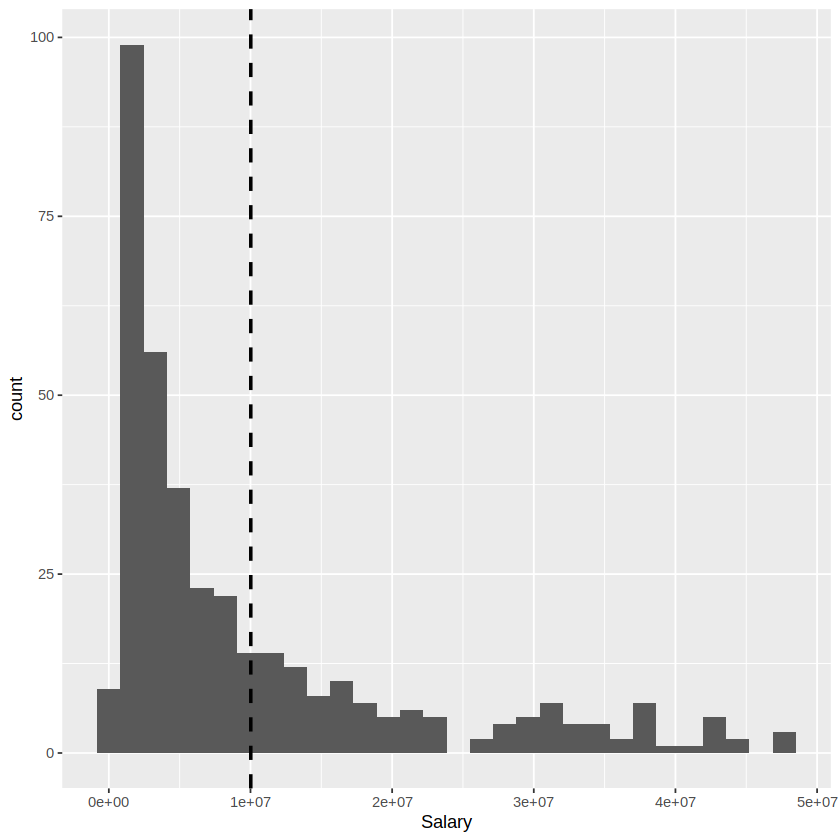

In [27]:
nba_salary_hist<- ggplot(nba_filtered, aes(x=Salary))+
                geom_histogram()+
                geom_vline(xintercept = 10021090, linetype = "dashed", linewidth = 1)

nba_salary_hist

#Histogram to visualize the distrbution of salary for nba players in 2022/23 season
#Added a vline at where the mean salary lies